# Pangyo AI Challenge 2021 - Mask Classification Baseline

## 라이브러리 호출 및 I/O

In [1]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# # 시드(seed) 설정

# RANDOM_SEED = 2021
# torch.manual_seed(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [5]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [6]:
# working directory 지정
ROOT_PATH = './'
DATA_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, ' weights')
NUMPY_DIR = os.path.join(ROOT_PATH, 'numpy')
CSV_DIR = os.path.join(ROOT_PATH, 'csv')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EARLY_STOPPING_PATIENCE = 5
INPUT_SHAPE = (180, 90)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):

        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        if os.path.isfile(os.path.join(RESULT_DIR, 'total.pkl')):
            self.db = pd.read_pickle(os.path.join(RESULT_DIR, 'total.pkl'))
        else:
            self.db = self.data_loader()
            self.db = self.db.sample(frac=1).reset_index()
            self.db.to_pickle(os.path.join(RESULT_DIR, 'total.pkl'))
            
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
            
        mask_image_list = os.listdir(os.path.join(self.data_dir, 'Mask'))
        nomask_image_list = os.listdir(os.path.join(self.data_dir, 'NoMask'))
        mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
        nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
        mask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'Mask', x), mask_image_list))
        nomask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'NoMask', x), nomask_image_list))

        # encoding label (Mask : 1, No Mask : 0)
        mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
        nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
        db = mask_df.append(nomask_df, ignore_index=True)
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']


## Model

In [12]:
# !pip install git+https://github.com/rwightman/pytorch-image-models.git

In [8]:
import timm

In [13]:
# timm.list_models(pretrained=True)

In [14]:
BACKBONE = 'efficientnet_b4'

In [11]:
from torch.nn import functional as F
from efficientnet_pytorch import EfficientNet

class MaskClassifier(nn.Module):
    def __init__(self):
        super(MaskClassifier, self).__init__()
        self.model = timm.create_model(BACKBONE, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classfier = nn.Linear(n_features, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_img):
        x = self.model(input_img)
        x = self.softmax(x)
        return x

## Trainer

In [13]:

class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## Metrics

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

## 학습을 위한 객체 선언

In [15]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 1518 Val set samples: 169


In [16]:
model = MaskClassifier().to(device)

In [17]:

# Save Initial Model
torch.save({'model':model.state_dict()}, os.path.join(RESULT_DIR, 'initial.pt'))

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
criterion = nn.CrossEntropyLoss()
metric_fn = get_metric_fn

# Set system logger
system_logger = get_logger(name='train',file_path='train_log.log')

# Set trainer
trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)

# Set earlystopper
# early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE, verbose=True, logger=system_logger)

In [18]:
train_loss_history = []
train_acc_history = []

valid_loss_history = []
valid_acc_history = []

best_val_loss = None
best_val_acc = None

criterion = 1E+8
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    train_loss_history.append(trainer.train_mean_loss)
    train_acc_history.append(trainer.train_score)
    
    valid_loss_history.append(trainer.val_mean_loss)
    valid_acc_history.append(trainer.validation_score)

    # don't use early stopper
    
    if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
        best_val_loss = trainer.val_mean_loss
        criterion = trainer.val_mean_loss
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, os.path.join(RESULT_DIR, f'{BACKBONE}_best.pt'))

best_val_acc = max(valid_acc_history)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 6.981512764666943, Acc: 0.0, ROC: 0.4212270133164236
Epoch 0, Val loss: 7.598448324203491, Acc: 0.0, ROC: 0.3048855905998763


  5%|▌         | 1/20 [00:11<03:42, 11.71s/it]

Epoch 1, Train loss: 6.599768734992819, Acc: 0.4163372859025033, ROC: 0.5184844641724793
Epoch 1, Val loss: 6.65063591003418, Acc: 0.863905325443787, ROC: 0.6006493506493507


 10%|█         | 2/20 [00:22<03:24, 11.38s/it]

Epoch 2, Train loss: 6.100078273326792, Acc: 0.8748353096179183, ROC: 0.7165880627774254


 15%|█▌        | 3/20 [00:33<03:08, 11.11s/it]

Epoch 2, Val loss: 6.654592037200928, Acc: 0.863905325443787, ROC: 0.5802411873840445
Epoch 3, Train loss: 6.099320487773165, Acc: 0.8748353096179183, ROC: 0.7750396322130627


 20%|██        | 4/20 [00:44<02:55, 11.00s/it]

Epoch 3, Val loss: 6.653028535842895, Acc: 0.8579881656804734, ROC: 0.6263141620284478
Epoch 4, Train loss: 6.098910438253524, Acc: 0.8748353096179183, ROC: 0.7488447209892201
Epoch 4, Val loss: 6.641508722305298, Acc: 0.8698224852071006, ROC: 0.6089981447124304


 25%|██▌       | 5/20 [00:55<02:47, 11.15s/it]

Epoch 5, Train loss: 6.099275756389536, Acc: 0.8748353096179183, ROC: 0.7351616994292962


 30%|███       | 6/20 [01:06<02:33, 11.00s/it]

Epoch 5, Val loss: 6.6479260444641115, Acc: 0.8698224852071006, ROC: 0.6179653679653679
Epoch 6, Train loss: 6.098928502265443, Acc: 0.8748353096179183, ROC: 0.7092125079264426


 35%|███▌      | 7/20 [01:17<02:22, 10.94s/it]

Epoch 6, Val loss: 6.663206481933594, Acc: 0.863905325443787, ROC: 0.6307977736549165
Epoch 7, Train loss: 6.098771348912665, Acc: 0.8748353096179183, ROC: 0.7443107958148383


 40%|████      | 8/20 [01:28<02:11, 10.98s/it]

Epoch 7, Val loss: 6.654146146774292, Acc: 0.8579881656804734, ROC: 0.5531849103277674
Epoch 8, Train loss: 6.0989390687739595, Acc: 0.8748353096179183, ROC: 0.7544903297400127


 45%|████▌     | 9/20 [01:39<01:59, 10.90s/it]

Epoch 8, Val loss: 6.65067868232727, Acc: 0.863905325443787, ROC: 0.6167285095856525
Epoch 9, Train loss: 6.098802637546621, Acc: 0.8748353096179183, ROC: 0.7478578788839569


 50%|█████     | 10/20 [01:49<01:48, 10.83s/it]

Epoch 9, Val loss: 6.642826509475708, Acc: 0.8698224852071006, ROC: 0.6600185528756957
Epoch 10, Train loss: 6.098976226563149, Acc: 0.8748353096179183, ROC: 0.7192315313887128


 55%|█████▌    | 11/20 [02:00<01:37, 10.81s/it]

Epoch 10, Val loss: 6.644205141067505, Acc: 0.863905325443787, ROC: 0.548082869511441
Epoch 11, Train loss: 6.09879389215023, Acc: 0.8748353096179183, ROC: 0.7463419467343055
Epoch 11, Val loss: 6.641312074661255, Acc: 0.863905325443787, ROC: 0.6422387136672851


 60%|██████    | 12/20 [02:11<01:26, 10.87s/it]

Epoch 12, Train loss: 6.098690530087086, Acc: 0.8748353096179183, ROC: 0.7060439124920735


 65%|██████▌   | 13/20 [02:22<01:15, 10.82s/it]

Epoch 12, Val loss: 6.642892122268677, Acc: 0.8698224852071006, ROC: 0.5712739641311071
Epoch 13, Train loss: 6.09901909118003, Acc: 0.8748353096179183, ROC: 0.7233235573874446


 70%|███████   | 14/20 [02:33<01:04, 10.77s/it]

Epoch 13, Val loss: 6.642826890945434, Acc: 0.8698224852071006, ROC: 0.550865800865801
Epoch 14, Train loss: 6.098890248765337, Acc: 0.8748353096179183, ROC: 0.7162274096385544


 75%|███████▌  | 15/20 [02:43<00:54, 10.82s/it]

Epoch 14, Val loss: 6.649047803878784, Acc: 0.863905325443787, ROC: 0.602504638218924
Epoch 15, Train loss: 6.09908498094437, Acc: 0.8748353096179183, ROC: 0.7274175649968295


 80%|████████  | 16/20 [02:54<00:43, 10.76s/it]

Epoch 15, Val loss: 6.644187498092651, Acc: 0.863905325443787, ROC: 0.611626468769326
Epoch 16, Train loss: 6.098984282067481, Acc: 0.8748353096179183, ROC: 0.7168555802155993


 85%|████████▌ | 17/20 [03:05<00:32, 10.71s/it]

Epoch 16, Val loss: 6.649032735824585, Acc: 0.863905325443787, ROC: 0.6201298701298701
Epoch 17, Train loss: 6.098799664923486, Acc: 0.8748353096179183, ROC: 0.7099793912492074


 90%|█████████ | 18/20 [03:15<00:21, 10.69s/it]

Epoch 17, Val loss: 6.663610982894897, Acc: 0.863905325443787, ROC: 0.5977118119975263
Epoch 18, Train loss: 6.098930800214727, Acc: 0.8748353096179183, ROC: 0.7028990963855422


 95%|█████████▌| 19/20 [03:26<00:10, 10.67s/it]

Epoch 18, Val loss: 6.64409122467041, Acc: 0.863905325443787, ROC: 0.6034322820037106
Epoch 19, Train loss: 6.098977378074159, Acc: 0.8748353096179183, ROC: 0.7412016487000633


100%|██████████| 20/20 [03:37<00:00, 10.85s/it]

Epoch 19, Val loss: 6.652088737487793, Acc: 0.863905325443787, ROC: 0.6188930117501545


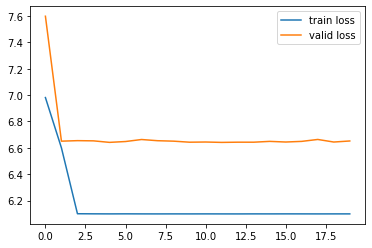

In [19]:
plt.plot(train_loss_history, label="train loss")
plt.plot(valid_loss_history, label="valid loss")
plt.legend()
plt.show()

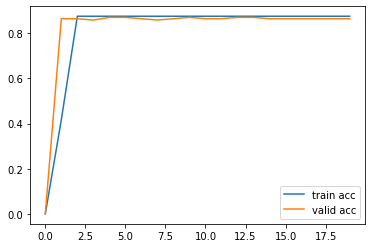

In [20]:
plt.plot(train_acc_history, label="train acc")
plt.plot(valid_acc_history, label="valid acc")
plt.legend()
plt.show()

In [21]:
save_dict = {'backbone':BACKBONE,
             'best_val_loss':best_val_loss,
             'best_val_acc':best_val_acc,
             'epochs':EPOCHS,
             'input_shape':INPUT_SHAPE,
             'augmentation':None,
             'optimizer':'Adam',
             'scheduler':None,
             'attention_module':None,
             'learning_rate':LEARNING_RATE,
             'batch_size':BATCH_SIZE,
             'loss':'CrossEntropyLoss',
             'freeze':None,
             'randomeseed':seed,
             'train_loss':train_loss_history,
             'train_acc':train_acc_history,
             'valid_loss':valid_loss_history,
             'valid_acc':valid_acc_history}

with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}.json", 'w') as f:
    json.dump(save_dict, f)

In [22]:
with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}.json", 'r') as f:
    load_dict = json.load(f)

In [23]:
# check how it looks
# load_dict

In [24]:
save_csv = pd.read_csv(os.path.join(CSV_DIR, 'experiment.csv'))

In [35]:
save_csv = save_csv.append(load_dict, ignore_index=True)

In [36]:
save_csv.to_csv(os.path.join(CSV_DIR, 'experiment.csv'), 
                index=False
               )

In [37]:
load_csv = pd.read_csv(os.path.join(CSV_DIR, 'experiment.csv'))

In [38]:
load_csv

,backbone,best_val_loss,best_val_acc,epochs,input_shape,augmentation,optimizer,scheduler,attention_module,learning_rate,batch_size,loss,freeze,randomeseed,train_loss,train_acc,valid_loss,valid_acc
0,efficientnet_b4,6.641312,0.869822,20.0,"[180, 90]",NaN,Adam,NaN,NaN,0.00001,16.0,CrossEntropyLoss,NaN,100.0,"[6.981512764666943, 6.599768734992819, 6.10007...","[0.0, 0.4163372859025033, 0.8748353096179183, ...","[7.598448324203491, 6.65063591003418, 6.654592...","[0.0, 0.863905325443787, 0.863905325443787, 0...."


## Inference

In [28]:
TRAINED_MODEL_PATH = os.path.join(RESULT_DIR, f'{BACKBONE}_best.pt')

#### Test set Loader

In [29]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [30]:
DATA_DIR=os.path.join(ROOT_PATH, 'test')

# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


In [31]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_num_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in enumerate(test_dataloader):
        img = img.to(device)
        pred = model(img)
        file_num_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

#### Save results as csv file

In [32]:
df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
df.sort_values(by=['file_name'], inplace=True)
df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)